# Capstone Project - The Battle of Neighborhoods

### Import all necessary libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import folium
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans



### Import Population data of Canada by Post code

Population data will be used in master dataset
source: Statistics Canada Open portal

Load csv datda and preprocess them

In [2]:
Data_Canada = pd.read_csv ("Canada Population 2016.csv")
Data_Toronto = Data_Canada[Data_Canada['Province or territory'] == ('Ontario')]
Data_Toronto.reset_index (inplace=True, drop=True)
Data_Toronto.head()


,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,K0A,K0A,Ontario,NaN,103474.0,40512.0,38794.0
1,K0B,K0B,Ontario,NaN,20945.0,9395.0,8714.0
2,K0C,K0C,Ontario,NaN,52154.0,22366.0,21132.0
3,K0E,K0E,Ontario,NaN,38903.0,18248.0,16177.0
4,K0G,K0G,Ontario,NaN,37097.0,18931.0,15121.0


###### Drop unnessary columns from population database

In [3]:
Data_Toronto_Rev = Data_Toronto.drop(['Geographic name', 'Province or territory', 'Total private dwellings, 2016', 'Private dwellings occupied by usual residents, 2016', 'Incompletely enumerated Indian reserves and Indian settlements, 2016'], axis = 1)



### Import Toronto Post code to append to the Dataset

Import neighbors and boroughs data from wikipedia

In [4]:
# Load source and parse html strings
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source)    

print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":861324217,"wgRevisionId":861324217,"wgArticleId":539066,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

In [5]:
match = soup.find('table', class_= 'wikitable sortable')
#print(match)

# Create an empty list 
Lists = []

# Loop through each text and put it in a list
for index in match.find_all('tr'):
    text = index.text
    #print(text)
    Lists.append(text)

# Make a list transformed into dataframe
Lists = [i.split('\n') for i in Lists] 
List = pd.DataFrame(Lists[1:], columns =Lists[0])

## List = List[['Borough']!="Not assigned"]
   
    #List.columns.tolist()
    #List.shape
    #List[[""]]

List.head()


,,Postcode,Borough,Neighbourhood,
0,,M1A,Not assigned,Not assigned,
1,,M2A,Not assigned,Not assigned,
2,,M3A,North York,Parkwoods,
3,,M4A,North York,Victoria Village,
4,,M5A,Downtown Toronto,Harbourfront,


Preprocess the dataset

In [6]:
## Dropping last unnecessary column, resetting index, removing not assigned rows
List_filtered = List[List.Borough != 'Not assigned']
ListM = List_filtered.iloc[:,~List_filtered.columns.duplicated()]
ListM = ListM.reset_index (drop=True)

ListM.loc[ListM["Neighbourhood"] == "Not assigned", "Neighbourhood"] = ListM["Borough"]

ListM.head()


,,Postcode,Borough,Neighbourhood
0,,M3A,North York,Parkwoods
1,,M4A,North York,Victoria Village
2,,M5A,Downtown Toronto,Harbourfront
3,,M5A,Downtown Toronto,Regent Park
4,,M6A,North York,Lawrence Heights


In [7]:
Data_Toronto_Rev.head()


,Geographic code,"Population, 2016"
0,K0A,103474.0
1,K0B,20945.0
2,K0C,52154.0
3,K0E,38903.0
4,K0G,37097.0


In [8]:
#Population = Data_Toronto_Rev [ListM['Postcode'] == Data_Toronto_Rev['Population, 2016']]

For each FSA add population from previous loaded dataset

In [9]:
Toronto =[]
for code in Data_Toronto_Rev['Geographic code']:
    #print(code)
    if code in list(ListM['Postcode']):
        
        Toronto.append(True)
    else:
        
        Toronto.append(False)
        
Toronto = pd.DataFrame (Toronto)
Toronto.shape

(523, 1)

Preprocessing dataset

In [10]:
df = Data_Toronto_Rev.join(Toronto)
df.columns = ['Geographic code', 'Population, 2016', 'Toronto or Not']

df2 = df[ df['Toronto or Not'] == True]
df2.reset_index(inplace = True , drop=True)
df2 = df2.drop(['Toronto or Not'], axis=1)


In [11]:
df3 = ListM.set_index('Postcode').join(df2.set_index ('Geographic code'))
df3 = df3.reset_index(drop=False)
df3 = df3.drop([''],axis=1)
cols = df3.columns.tolist()
cols[0:1]
cols = cols[0:1] + cols [-1:] + cols[1:3]
df3 = df3[cols]

df3.columns = ['Postcode', 'Population, 2016', 'Borough', 'Neighbourhood']
df3

,Postcode,"Population, 2016",Borough,Neighbourhood
0,M1B,66108.0,Scarborough,Rouge
1,M1B,66108.0,Scarborough,Malvern
2,M1C,35626.0,Scarborough,Highland Creek
3,M1C,35626.0,Scarborough,Rouge Hill
4,M1C,35626.0,Scarborough,Port Union
5,M1E,46943.0,Scarborough,Guildwood
6,M1E,46943.0,Scarborough,Morningside
7,M1E,46943.0,Scarborough,West Hill
8,M1G,29690.0,Scarborough,Woburn
9,M1H,24383.0,Scarborough,Cedarbrae


## Importing Income data by FSA

Data source: Statistics Canada Open Portal

In [12]:
Data_Income = pd.read_csv ("Toronto Income by FSA 2015.csv")
#Data_Income = Data_Income[Data_Canada['Province or territory'] == ('Ontario')]
#Data_Income.reset_index (inplace=True, drop=True)
Data_Income.head()


,Prov/Terr,FSA,Total,Total Income,Avg Income,"Under $5,000","$5,000 to $9,999","$10,000 to $14,999","$15,000 to $19,999","$20,000 to $24,999",...,"$45,000 to $49,999","$50,000 to $54,999","$55,000 to $59,999","$60,000 to $69,999","$70,000 to $79,999","$80,000 to $89,999","$90,000 to $99,999","$100,000 to $149,999","$150,000 to $249,999","$250,000 and over"
0,35,M1B,51410,"1,577,233,000","30,679",8140,4340,5660,5470,3790,...,2280,1900,1560,2290,1550,920,720,1070,200,40
1,35,M1C,29080,"1,483,624,000","51,019",3340,1780,2250,2120,1630,...,1320,1200,1060,1850,1580,1210,1200,2250,770,270
2,35,M1E,36220,"1,320,927,000","36,470",4810,2970,3880,3610,2680,...,1550,1280,1140,1730,1350,930,840,1310,390,140
3,35,M1G,22820,"637,206,000","27,923",4300,2120,2730,2630,1760,...,860,640,540,800,610,400,280,440,80,20
4,35,M1H,19440,"615,223,000","31,647",3500,1510,2040,1870,1490,...,800,640,560,820,640,420,330,480,130,30


In [13]:
Data_Income.columns.tolist()
#Data_Income = Data_Income[Data_Income['Prov/Terr', 'FSA', 'Total', 'Total Income']]

['Prov/Terr',
 'FSA',
 'Total',
 'Total Income',
 'Avg Income',
 'Under $5,000',
 '$5,000 to $9,999',
 '$10,000 to $14,999',
 '$15,000 to $19,999',
 '$20,000 to $24,999',
 '$25,000 to $29,999',
 '$30,000 to $34,999',
 '$35,000 to $39,999',
 '$40,000 to $44,999',
 '$45,000 to $49,999',
 '$50,000 to $54,999',
 '$55,000 to $59,999',
 '$60,000 to $69,999',
 '$70,000 to $79,999',
 '$80,000 to $89,999',
 '$90,000 to $99,999',
 '$100,000 to $149,999',
 '$150,000 to $249,999',
 '$250,000 and over']

Preprocessing the dataset

In [14]:
Income_Cols = Data_Income.columns.tolist()
Income_Cols = Income_Cols[0:5]
Income_Cols
Data_Income = Data_Income[Income_Cols]
Data_Income.head()



,Prov/Terr,FSA,Total,Total Income,Avg Income
0,35,M1B,51410,"1,577,233,000","30,679"
1,35,M1C,29080,"1,483,624,000","51,019"
2,35,M1E,36220,"1,320,927,000","36,470"
3,35,M1G,22820,"637,206,000","27,923"
4,35,M1H,19440,"615,223,000","31,647"


In [15]:
type(Data_Income.iloc[0,1])

str

In [212]:
Data_Income.loc[Data_Income['Total'] == 0, ['Total Income', 'Avg Income']] = 0

Data_Income.head()

,Prov/Terr,FSA,Total,Total Income,Avg Income
0,35,M1B,51410,"1,577,233,000","30,679"
1,35,M1C,29080,"1,483,624,000","51,019"
2,35,M1E,36220,"1,320,927,000","36,470"
3,35,M1G,22820,"637,206,000","27,923"
4,35,M1H,19440,"615,223,000","31,647"


Append Income dataset to the master database

In [17]:
DB = Data_Income.set_index('FSA').join(df3.set_index('Postcode'))
DB = DB.drop ('Prov/Terr', axis=1)
DB.reset_index(drop=False, inplace=True)
DB.head()

,index,Total,Total Income,Avg Income,"Population, 2016",Borough,Neighbourhood
0,M1B,51410,"1,577,233,000","30,679",66108.0,Scarborough,Rouge
1,M1B,51410,"1,577,233,000","30,679",66108.0,Scarborough,Malvern
2,M1C,29080,"1,483,624,000","51,019",35626.0,Scarborough,Highland Creek
3,M1C,29080,"1,483,624,000","51,019",35626.0,Scarborough,Rouge Hill
4,M1C,29080,"1,483,624,000","51,019",35626.0,Scarborough,Port Union


## Import Coordinates of each region

In [213]:
#import xlrd
Coord = pd.read_csv ('Geospatial Coordinates.csv')

DB2 = DB.set_index('index').join(Coord.set_index('Postal Code'))
DB2.reset_index(drop=False, inplace=True)
DB2.columns = DB2.columns.tolist()
DBlist = list(DB2.columns)
DBlist[0] = 'Post Code'
DB2.columns = DBlist

DB2 = DB2.drop('Neighbourhood', axis=1)
DB2 = DB2.drop_duplicates (inplace=False)
DB2.reset_index (drop=True, inplace=True)

DB2.head()

,Post Code,Total,Total Income,Avg Income,"Population, 2016",Borough,Latitude,Longitude
0,M1B,51410,"1,577,233,000","30,679",66108.0,Scarborough,43.806686,-79.194353
1,M1C,29080,"1,483,624,000","51,019",35626.0,Scarborough,43.784535,-79.160497
2,M1E,36220,"1,320,927,000","36,470",46943.0,Scarborough,43.763573,-79.188711
3,M1G,22820,"637,206,000","27,923",29690.0,Scarborough,43.770992,-79.216917
4,M1H,19440,"615,223,000","31,647",24383.0,Scarborough,43.773136,-79.239476


### Get coordinate of Toronto and create a map of Toronto with Neighbourhood marker

In [218]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, Ontario'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Ontario are {}, {}.'.format(latitude, longitude))


c:\users\buy\appdata\local\programs\python\python37-32\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto, Ontario are 43.653963, -79.387207.


### Get Folium to creat a map of Toronto

In [220]:
## create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(DB2['Latitude'], DB2['Longitude'], DB2['Post Code']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_toronto)  
    
map_toronto

Query FourSquare to search for restaurants of each region within 5000m

In [221]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius 5km
query = 'restaurants'

CLIENT_ID = '4LNI4B1PUDKGMMB33UF34AKZXS1CQ0P1KWZTEJKVO3ZCJRVU'
CLIENT_SECRET = 'LXEMHG4N2BSUNMI0P4GGLJ3N23C22TT0WR0C5MSEBAUHEYLR'
VERSION = '20180605'

#latitude = 43.750072
#longitude = -79.295849

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude,  
    query,
    radius)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=4LNI4B1PUDKGMMB33UF34AKZXS1CQ0P1KWZTEJKVO3ZCJRVU&client_secret=LXEMHG4N2BSUNMI0P4GGLJ3N23C22TT0WR0C5MSEBAUHEYLR&v=20180605&ll=43.653963,-79.387207&query=restaurants&radius=5000'

In [222]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bb13bd66a607169107472cd'},
 'response': {'venues': [{'id': '4b295e10f964a520ba9d24e3',
    'name': 'Richtree Natural Market Restaurants',
    'location': {'address': '14 Queen St W',
     'lat': 43.652614361741726,
     'lng': -79.38023131683906,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.652614361741726,
       'lng': -79.38023131683906}],
     'distance': 581,
     'postalCode': 'M5H 3X4',
     'cc': 'CA',
     'city': 'Toronto',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['14 Queen St W', 'Toronto ON M5H 3X4', 'Canada']},
    'categories': [{'id': '4bf58dd8d48988d1c4941735',
      'name': 'Restaurant',
      'pluralName': 'Restaurants',
      'shortName': 'Restaurant',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1538341846',
    'hasPerk': False},
   {'id': '4d8a7d78bc848cfabd63db2b',
    'na

In [223]:
# function that extracts the category of the venue
def get_category_type(rrow):
    try:
        categories_list = rrow['venues.categories']
    except:
        categories_list = rrow['categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


In [224]:
venues = results['response']['venues']
#lat = results['response']['venues'][0]['location']['lat']
#lng = results['response']['venues'][0]['location']['lng']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['categories', 'name', 'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

#nearby_venues.head()

nearby_venues


,categories,name,lat,lng
0,Restaurant,Richtree Natural Market Restaurants,43.652614,-79.380231
1,Restaurant,Valens Restaurants,43.656096,-79.392839
2,Restaurant,Imago Restaurants,43.647910,-79.390810
3,Fast Food Restaurant,Marigold Indian Bistro | Indian Restaurants in...,43.644302,-79.390002
4,Office,Restaurants Canada,43.642628,-79.425337
5,Sandwich Place,Subway,43.646459,-79.389506
6,Sandwich Place,Subway,43.646199,-79.387655
7,Sandwich Place,Subway,43.665972,-79.407075
8,Office,Oliver & Bonacini Restaurants,43.708278,-79.398480
9,Furniture / Home Store,Nikalou Restaurant Supply,43.647614,-79.402663


## Get nearby restaurants of all region within 700m

In [87]:
def GetNearbyVenues(names, latitudes, longitudes, radius=700):
      
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
       
        # create the API request URL
        query = 'restaurants'
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            radius)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Post Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#results['response']['venues']

In [88]:
toronto_venues = GetNearbyVenues(names=DB2['Post Code'],
                                   latitudes=DB2['Latitude'],
                                   longitudes=DB2['Longitude']
                                  )

M1B
M1C
M1E
M1G
M1H
M1J
M1K
M1L
M1M
M1N
M1P
M1R
M1S
M1T
M1V
M1W
M1X
M2H
M2J
M2K
M2L
M2M
M2N
M2P
M2R
M3A
M3B
M3C
M3H
M3J
M3K
M3L
M3M
M3N
M4A
M4B
M4C
M4E
M4G
M4H
M4J
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5M
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6A
M6B
M6C
M6E
M6G
M6H
M6J
M6K
M6L
M6M
M6N
M6P
M6R
M6S
M7A
M7Y
M8V
M8W
M8X
M8Y
M8Z
M9A
M9B
M9C
M9L
M9M
M9N
M9P
M9R
M9V
M9W


Assign labels to the master dataset

In [110]:
toronto = toronto_venues.groupby ('Post Code').count()
torontocols = toronto.columns.tolist()
torontocols = torontocols [-1:]
toronto = toronto[torontocols]
toronto2=  toronto.reset_index(drop=False, inplace=False)
toronto2

,Post Code,Venue Category
0,M1V,1
1,M4H,1
2,M4K,1
3,M5B,1
4,M5C,1
5,M5G,1
6,M5H,4
7,M5J,2
8,M5K,5
9,M5L,2


In [250]:
DB3 = DB2.set_index('Post Code').join(toronto2.set_index('Post Code'))
DB3= DB3.fillna(0)
DB4 = DB3.drop (['Borough'], axis=1)
DB4['Total Income'] = DB4['Total Income'].str.replace(',', '')
DB4['Avg Income'] = DB4['Avg Income'].str.replace(',', '')
DB4 = DB4.reset_index(drop=False, inplace=False)
DB4.head()

,Post Code,Total,Total Income,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category
0,M1B,51410,1577233000,30679,66108.0,43.806686,-79.194353,0.0
1,M1C,29080,1483624000,51019,35626.0,43.784535,-79.160497,0.0
2,M1E,36220,1320927000,36470,46943.0,43.763573,-79.188711,0.0
3,M1G,22820,637206000,27923,29690.0,43.770992,-79.216917,0.0
4,M1H,19440,615223000,31647,24383.0,43.773136,-79.239476,0.0


### Perform K-means Clustering for each neighbourhood

In [175]:
from sklearn.preprocessing import StandardScaler

X = DB4.values[:,1:6].astype(float)

X = np.nan_to_num(X)

cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset


array([[ 2.51164138e+00,  7.40679418e-01, -6.63800315e-01,
         2.60661993e+00,  1.94918965e+00],
       [ 6.63254458e-01,  5.90943678e-01, -3.04956050e-01,
         5.86012256e-01,  1.52344675e+00],
       [ 1.25427473e+00,  3.30695670e-01, -5.61633789e-01,
         1.33619981e+00,  1.12055049e+00],
       [ 1.45077022e-01, -7.62975560e-01, -7.12422478e-01,
         1.92523404e-01,  1.26315222e+00],
       [-1.34705683e-01, -7.98139281e-01, -6.46722574e-01,
        -1.59269947e-01,  1.30435768e+00],
       [ 4.94391524e-01, -5.14545301e-01, -6.87970258e-01,
         6.57139873e-01,  7.58479138e-01],
       [ 1.38423297e+00,  2.14411152e-02, -6.78637484e-01,
         1.43503604e+00,  4.35489439e-01],
       [ 4.07476778e-01, -4.37648355e-01, -6.34443537e-01,
         5.49884994e-01,  1.12259492e-01],
       [-2.52247529e-01, -4.77335708e-01, -4.06363957e-01,
        -2.56714120e-01,  2.12285394e-01],
       [-3.37506756e-01, -2.73617105e-01, -2.25706864e-01,
        -3.08220326e-01

Assign labels to the dataset

In [228]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)

In [229]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:]
labels = kmeans.labels_

In [267]:
# append to DB4 dataframe
DB4['Labels'] = labels

DB4.head()

,Post Code,Total,Total Income,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
0,M1B,51410,1577233000,30679.0,66108.0,43.806686,-79.194353,0.0,3
1,M1C,29080,1483624000,51019.0,35626.0,43.784535,-79.160497,0.0,3
2,M1E,36220,1320927000,36470.0,46943.0,43.763573,-79.188711,0.0,4
3,M1G,22820,637206000,27923.0,29690.0,43.770992,-79.216917,0.0,1
4,M1H,19440,615223000,31647.0,24383.0,43.773136,-79.239476,0.0,1


### Creat a map to visualize clusters

In [268]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color ascheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(DB4['Latitude'], DB4['Longitude'], DB4['Post Code'], DB4['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

List of cluster 0 regions

In [281]:
CL0 = DB4.loc[DB4['Labels'] == 0, DB4.columns[[0,3,4,7]]]
CL0

,Post Code,Avg Income,"Population, 2016",Venue Category
22,M2N,44988.0,75897.0,0.0
44,M4N,211829.0,15330.0,0.0
49,M4V,167263.0,18241.0,0.0
50,M4W,202622.0,14561.0,0.0
62,M5M,121094.0,25975.0,0.0
64,M5P,145550.0,19423.0,0.0
65,M5R,120758.0,26496.0,1.0
68,M5V,76541.0,49195.0,0.0
84,M6S,79046.0,34299.0,0.0
92,M9A,85129.0,35594.0,0.0


In [284]:
print(CL0.mean())
DB4.describe()

Avg Income          125482.0
Population, 2016     31501.1
Venue Category           0.1
dtype: float64


,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725,2.343137
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770,1.417676
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000,1.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000,3.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000,4.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000,4.000000


##### Interpretion: Most of regions (9/10) have no restaurants within 700m with average income of more than 125k which is double the average of Toronto. Average population however in cluster 0 regions are almost half the average population of Toronto region. Therefore Cluster 0 region includes high-income neighbours but they are not many.

In [285]:
CL1= DB4.loc[DB4['Labels'] == 1, DB4.columns[[0,3,4,7]]]
CL1

,Post Code,Avg Income,"Population, 2016",Venue Category
3,M1G,27923.0,29690.0,0.0
4,M1H,31647.0,24383.0,0.0
5,M1J,29309.0,36699.0,0.0
7,M1L,32343.0,35081.0,0.0
8,M1M,45271.0,22913.0,0.0
11,M1R,33372.0,29858.0,0.0
17,M2H,41668.0,24497.0,0.0
23,M2P,133868.0,7843.0,0.0
29,M3J,29158.0,25473.0,0.0
31,M3L,29835.0,17339.0,0.0


In [286]:
print(CL1.mean())
DB4.describe()

Avg Income          52079.413793
Population, 2016    20333.172414
Venue Category          0.344828
dtype: float64


,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725,2.343137
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770,1.417676
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000,1.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000,3.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000,4.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000,4.000000


#### Cluster 1 region has most of regions not having any restaurants within 700m but region "M5H" for example has 4 restaurants when demographic shows ~20k people having high income (~180k) leading to an intuition that the region has a high demand of restaurants wheter its saturated or not. Cluster 1 region overall has average income of ~52k which is less than Toronto average with only ~20k people living in. Non-luxurious type of restuarants are well suited as a start-up consideration.

In [287]:
CL2= DB4.loc[DB4['Labels'] == 2, DB4.columns[[0,3,4,7]]]
CL2

,Post Code,Avg Income,"Population, 2016",Venue Category
16,M1X,32308.0,15097.0,0.0
30,M3K,43444.0,5997.0,0.0
39,M4H,23701.0,19688.0,1.0
60,M5K,172631.0,0.0,5.0
61,M5L,237900.0,0.0,2.0
69,M5W,89029.0,15.0,1.0
70,M5X,386127.0,10.0,5.0
85,M7A,NaN,10.0,1.0
86,M7Y,NaN,10.0,0.0
95,M9L,30452.0,11950.0,0.0


In [288]:
print(CL2.mean())
DB4.describe()

Avg Income          126949.0
Population, 2016      5277.7
Venue Category           1.5
dtype: float64


,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725,2.343137
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770,1.417676
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000,1.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000,3.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000,4.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000,4.000000


#### Cluster region 2 is a region where people of average income of ~127k lives in but only ~5k lives in. There are on average of about 1.5 restaurants within 700m of radius which is relatively higher than cluster regions 0 or 1, which could be a sign be high deamnd for restaurants. Luxurious restaurants with high priced foods could potentially be the right choice for a start-up in this region.

In [289]:
CL3= DB4.loc[DB4['Labels'] == 3, DB4.columns[[0,3,4,7]]]
CL3

,Post Code,Avg Income,"Population, 2016",Venue Category
0,M1B,30679.0,66108.0,0.0
1,M1C,51019.0,35626.0,0.0
15,M1W,34021.0,48471.0,0.0
18,M2J,37689.0,58293.0,0.0
26,M3B,124592.0,13324.0,0.0
28,M3H,60157.0,37011.0,0.0
36,M4C,41353.0,46866.0,0.0
37,M4E,83258.0,25044.0,0.0
38,M4G,122920.0,19076.0,0.0
40,M4J,50672.0,35738.0,0.0


In [291]:
print(CL3.mean())
DB4.describe()

Avg Income          68664.500000
Population, 2016    35007.909091
Venue Category          0.045455
dtype: float64


,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725,2.343137
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770,1.417676
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000,1.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000,3.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000,4.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000,4.000000


#### Cluster region 3 has relatively higher population than any other clusters and they are also above Toronto average. Their average income looks to be around on par with Toronto average. Any kind of restuarants seem to work well depending on the choice of specific regions but the demand seems to be very low thus this is not the ideal region to open up a restaurant.

In [292]:
CL4= DB4.loc[DB4['Labels'] == 4, DB4.columns[[0,3,4,7]]]
CL4

,Post Code,Avg Income,"Population, 2016",Venue Category
2,M1E,36470.0,46943.0,0.0
6,M1K,29838.0,48434.0,0.0
9,M1N,55511.0,22136.0,0.0
10,M1P,31336.0,45571.0,0.0
12,M1S,31599.0,37769.0,0.0
13,M1T,32684.0,34588.0,0.0
14,M1V,28185.0,54680.0,1.0
19,M2K,55722.0,23852.0,0.0
20,M2L,117362.0,11717.0,0.0
21,M2M,40288.0,32320.0,0.0


In [294]:
print(CL4.mean())
DB4.describe()

Avg Income          54055.677419
Population, 2016    32403.709677
Venue Category          0.161290
dtype: float64


,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category,Labels
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725,2.343137
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770,1.417676
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000,1.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000,3.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000,4.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000,4.000000


#### Cluster region 4 seem very similar to cluster 3 where average income is below Toronto average and their average population is slightly above Toronto average. Demand for foods in this region doesnt seem to be stable and this is not the ideal location for a start-up to open up a restaurant unless they stretegically choose the region for a long term success.

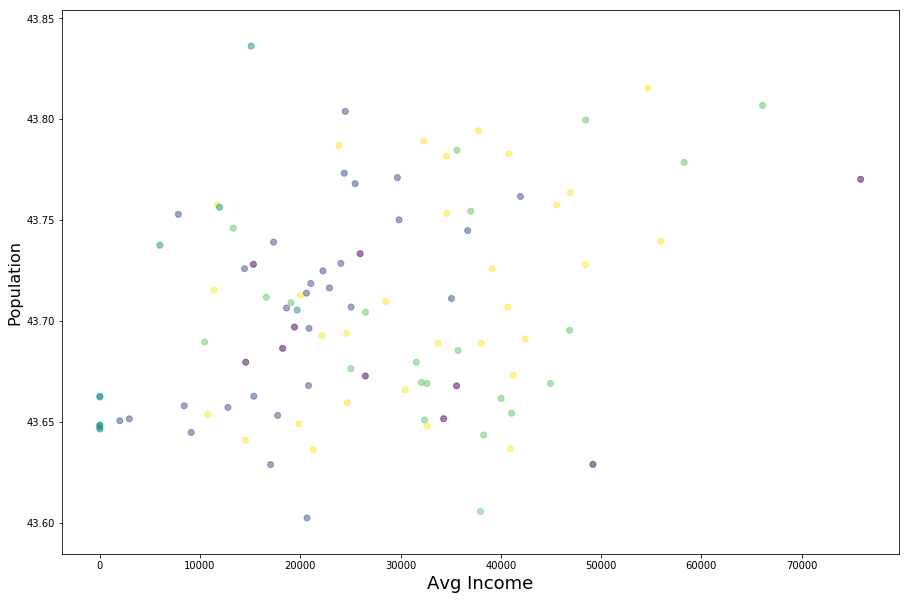

In [211]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

area = np.pi * (X[:, 1])**2  
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 3], X[:, 4], c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Avg Income', fontsize=18)
plt.ylabel('Population', fontsize=16)

plt.show()

In [262]:
DB4 ['Avg Income'] = DB4['Avg Income'].astype(float)

In [265]:
DB4.describe()

,Total,Avg Income,"Population, 2016",Latitude,Longitude,Venue Category
count,102.000000,100.000000,102.000000,102.000000,102.000000,102.000000
mean,21067.352941,69670.600000,26785.676471,43.705271,-79.395009,0.313725
std,12140.462575,56692.742335,15160.057881,0.052286,0.095146,0.889770
min,0.000000,23701.000000,0.000000,43.602414,-79.594054,0.000000
25%,13185.000000,33864.500000,16717.000000,43.661782,-79.462654,0.000000
50%,19430.000000,49424.000000,24866.500000,43.700636,-79.388790,0.000000
75%,28975.000000,77482.250000,36933.000000,43.745613,-79.340923,0.000000
max,71020.000000,386127.000000,75897.000000,43.836125,-79.160497,5.000000
